In [1]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sn
import os.path, sys, re
import time
from PIL import Image

from sktime.utils.data_processing import (
    from_3d_numpy_to_nested,
    from_multi_index_to_3d_numpy,
    from_nested_to_3d_numpy,
    from_multi_index_to_nested,
    from_nested_to_multi_index,
)

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
import sklearn.metrics as metrics
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import cross_val_predict

from sktime.classification.compose import ColumnEnsembleClassifier
from sktime.classification.dictionary_based import BOSSEnsemble
from sktime.classification.interval_based import TimeSeriesForestClassifier
from sktime.classification.shapelet_based import MrSEQLClassifier
from sktime.datasets import load_basic_motions
from sktime.transformations.panel.compose import ColumnConcatenator


In [2]:
cd ~/Desktop/Data_Science/Erdos_Institute/ecg-proj/ecg-copy/

/home/moise/Desktop/Data_Science/Erdos_Institute/ecg-proj/ecg-copy


### Data Preprocessing task

In [3]:
pathroot = "CSV_data_v2/"

In [4]:
LeadDict={'Lead1':np.array([[]]),'Lead2':np.array([[]]),'Lead3':np.array([[]]),'Lead4':np.array([[]]),
          'Lead5':np.array([[]]),'Lead6':np.array([[]]),'Lead7':np.array([[]]),'Lead8':np.array([[]]),
         'Lead9':np.array([[]]),'Lead10':np.array([[]]),'Lead11':np.array([[]]),'Lead12':np.array([[]])}

In [5]:
leadMinLen = {'Lead1':0,'Lead2':0,'Lead3':0,'Lead4':0,'Lead5':0,'Lead6':0,
           'Lead7':0,'Lead8':0,'Lead9':0,'Lead10':0,'Lead11':0,'Lead12':0}

In [6]:
ClassLabels={'ECGImagesofPatientthathaveHistoryofMI':0,'ECGImagesofPatientthathaveabnormalheartbeat':1,
            'ECGImagesofCOVID-19Patients':2,'NormalPersonECGImages':3,'ECGImagesofMyocardialInfarctionPatients':4}

In [7]:
"""
For every "x" value of the signal, average the "y" values over duplicates.

Inputs:
-------
df  data frame of two columns containing the signal "x" and "y" coordinates corresponding to "active" pixels

Outputs:
--------
signal numpy array of unique values ("y") of the signal
"""
def uniqValsSignal(df):
    xdf=df[0].to_numpy()
    ydf=df[1].to_numpy()
    unikVals = pd.unique(xdf)
    signal = np.zeros(len(unikVals))
    for i in range(len(unikVals)):
        mask = (xdf==unikVals[i])
        signal[i] = np.mean(ydf[mask])
    return signal

In [8]:
"""
Note:
-----

1) For the "time series", only the second column of every lead is extracted as signal.
2) Because of non-uniformity in signal lenght across both observations and Leads, the code
uses the minimum signal length across observation and leads, in order to make the date "proper
for multivariate time series classification.
"""

labelArr = np.array([])
for dirs in os.listdir(pathroot):
#     if dirs == 'ECGImagesofCOVID-19Patients':
#         continue
    t = time.time()
    count = 0
    print('Processing {0} folder ...'.format(dirs))
    if not os.path.isfile(dirs):
        for item in os.listdir(os.path.join(pathroot,dirs)):
            #print('Processing {0} file ...'.format(item))
            of, oe = os.path.splitext(item)
            if of[0]=='.':
                continue
            else:
                signal = pd.read_csv(os.path.join(pathroot,os.path.join(dirs,item)),header=None,sep=' ')#[1].to_numpy()
                signal = uniqValsSignal(signal)
            try:
                leadNum = int(of[-2:])
            except ValueError:
                leadNum = int(of[-1:])
            finally:
                leadKey = 'Lead'+str(leadNum)
            if leadNum == 13:
                continue
            if LeadDict[leadKey].shape[1] > 0:
                if len(signal)> leadMinLen[leadKey]:
                    signal = np.reshape(signal[:leadMinLen[leadKey]],(1,leadMinLen[leadKey]))
                    LeadDict[leadKey] = np.concatenate( (LeadDict[leadKey],signal) )
                else:
                    LeadDict[leadKey] = LeadDict[leadKey][:,:len(signal)]
                    LeadDict[leadKey] = np.concatenate( (LeadDict[leadKey],np.reshape(signal,(1,len(signal)))) )
                    leadMinLen[leadKey] = len(signal) 
            else:
                LeadDict[leadKey] = np.reshape(signal,(1,len(signal)))
                leadMinLen[leadKey] = len(signal)         
            count = count+1
        labelArr = np.append(labelArr,np.repeat(ClassLabels[dirs],len(LeadDict[leadKey])-len(labelArr))) ##Add labels
        t = time.time()-t
        print('{0} files processed in this folder in {1} sec...\n'.format(count,round(t)))    

Processing ECGImagesofPatientthathaveHistoryofMI folder ...
2064 files processed in this folder in 19 sec...

Processing ECGImagesofPatientthathaveabnormalheartbeat folder ...
2796 files processed in this folder in 29 sec...

Processing ECGImagesofCOVID-19Patients folder ...
3000 files processed in this folder in 14 sec...

Processing NormalPersonECGImages folder ...
3408 files processed in this folder in 33 sec...

Processing ECGImagesofMyocardialInfarctionPatients folder ...
2868 files processed in this folder in 28 sec...



In [9]:
"""
Post Processing:
---------------

1) Put all the leads on the same "time" scale/Length
2) Pull all the leads(2D) into a 3D array of shape (n_obs,n_col,n_timepoints)
3) Convert result from step 2 into a nested data frame.
"""

minLen = min(leadMinLen.values())
for key in LeadDict.keys():
    LeadDict[key] = LeadDict[key][:,:minLen]

dim1 = LeadDict['Lead1'].shape[0]
dim2 = len(LeadDict.keys())
dim3 = LeadDict['Lead1'].shape[1]
X3d = np.zeros((dim1,dim2,dim3))
for j in range(dim2):
    X3d[:,j,:] = list(LeadDict.values())[j]
    
X3d_nested=from_3d_numpy_to_nested(X3d)
X3d_nested.columns = list(LeadDict.keys())
X3d_nested['Label'] = labelArr
X3d_nested.to_csv('muti-lead-dataFrame.csv',index=False,float_format='%d')

In [10]:
X3d_nested

,Lead1,Lead2,Lead3,Lead4,Lead5,Lead6,Lead7,Lead8,Lead9,Lead10,Lead11,Lead12,Label
0,0 126.0 1 119.5 2 134.0 3 ...,0 105.0 1 104.5 2 104.5 3 ...,0 104.714286 1 117.250000 2 101...,0 35.957447 1 35.500000 2 46...,0 158.000000 1 157.333333 2 149...,0 119.5 1 116.5 2 125.5 3 ...,0 137.5 1 137.0 2 136.5 3 ...,0 156.0 1 154.0 2 153.5 3 ...,0 162.000000 1 162.000000 2 151...,0 155.0 1 154.5 2 155.5 3 ...,0 193.545455 1 3.500000 2 3...,0 89.000000 1 109.500000 2 91...,0.0
1,0 139.0 1 129.0 2 127.0 3 ...,0 103.0 1 103.0 2 102.0 3 ...,0 80.5 1 80.0 2 79.0 3 79....,0 67.5 1 72.0 2 77.0 3 ...,0 127.5 1 126.0 2 131.5 3 ...,0 130.0 1 139.0 2 130.5 3 ...,0 129.5 1 129.5 2 129.5 3 ...,0 155.5 1 155.5 2 155.5 3 ...,0 139.0 1 131.5 2 128.5 3 ...,0 153.5 1 149.0 2 151.0 3 ...,0 80.166667 1 77.071429 2 82...,0 109.000000 1 100.000000 2 111...,0.0
2,0 158.333333 1 158.333333 2 149...,0 103.5 1 106.5 2 110.5 3 ...,0 103.5 1 103.5 2 103.5 3 ...,0 97.5 1 97.5 2 97.0 3 ...,0 118.363636 1 97.000000 2 94...,0 116.666667 1 155.500000 2 156...,0 131.200000 1 136.166667 2 104...,0 108.5 1 100.0 2 112.5 3 ...,0 169.500000 1 153.000000 2 145...,0 156.0 1 156.0 2 157.5 3 ...,0 145.5 1 145.5 2 145.5 3 ...,0 107.170732 1 104.000000 2 121...,0.0
3,0 116.5 1 117.5 2 126.0 3 ...,0 100.5 1 100.5 2 101.5 3 ...,0 104.5 1 104.5 2 104.0 3 ...,0 63.0 1 60.0 2 67.5 3 ...,0 130.0 1 123.5 2 129.5 3 ...,0 131.5 1 130.0 2 131.5 3 ...,0 140.5 1 150.0 2 144.5 3 ...,0 155.0 1 155.0 2 155.0 3 ...,0 169.500000 1 153.000000 2 145...,0 119.5 1 122.0 2 129.5 3 ...,0 154.055944 1 136.396396 2 44...,0 121.714286 1 144.000000 2 133...,0.0
4,0 157.000000 1 157.000000 2 148...,0 106.5 1 106.5 2 106.0 3 ...,0 107.0 1 106.0 2 106.0 3 ...,0 58.5 1 70.0 2 86.0 3 ...,0 141.0 1 136.5 2 138.0 3 ...,0 155.5 1 158.5 2 156.5 3 ...,0 131.0 1 130.5 2 130.0 3 ...,0 133.5 1 133.0 2 146.5 3 ...,0 139.333333 1 159.357143 2 156...,0 137.0 1 138.5 2 145.5 3 ...,0 137.5 1 138.0 2 146.5 3 ...,0 140.0 1 135.0 2 142.0 3 ...,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1173,0 130.5 1 127.5 2 127.0 3 ...,0 100.5 1 100.0 2 99.5 3 ...,0 107.0 1 107.0 2 109.0 3 ...,0 57.0 1 67.5 2 82.5 3 ...,0 110.5 1 107.5 2 123.5 3 ...,0 142.5 1 145.0 2 156.5 3 ...,0 97.0 1 124.5 2 105.5 3 ...,0 127.5 1 126.0 2 127.5 3 ...,0 142.5 1 137.5 2 137.5 3 ...,0 133.0 1 132.5 2 132.5 3 ...,0 4.0 1 12.5 2 19.0 3 ...,0 138.5 1 143.0 2 143.5 3 ...,4.0
1174,0 92.5 1 78.5 2 92.0 3 ...,0 102.5 1 103.0 2 103.0 3 ...,0 87.5 1 87.5 2 87.5 3 ...,0 74.0 1 72.5 2 74.5 3 ...,0 71.5 1 74.5 2 83.0 3 ...,0 113.0 1 111.0 2 119.0 3 ...,0 141.600000 1 133.250000 2 122...,0 121.0 1 120.5 2 120.0 3 ...,0 87.0 1 86.5 2 86.0 3 ...,0 140.0 1 148.5 2 142.0 3 ...,0 137.909091 1 140.000000 2 137...,0 117.5 1 125.0 2 127.0 3 ...,4.0
1175,0 130.0 1 131.5 2 138.0 3 ...,0 103.0 1 103.5 2 103.5 3 ...,0 97.0 1 96.5 2 96.0 3 ...,0 54.5 1 40.0 2 70.0 3 ...,0 142.000 1 147.000 2 142.000 3...,0 135.0 1 145.0 2 138.5 3 ...,0 97.0 1 124.5 2 105.5 3 ...,0 137.5 1 144.5 2 153.5 3 ...,0 87.0 1 86.5 2 86.0 3 ...,0 156.5 1 156.5 2 155.5 3 ...,0 135.0 1 135.0 2 135.5 3 ...,0 128.0 1 124.5 2 136.5 3 ...,4.0
1176,0 127.0 1 133.5 2 137.5 3 ...,0 100.5 1 100.0 2 102.5 3 ...,0 91.5 1 94.5 2 96.0 3 ...,0 74.0 1 72.5 2 74.5 3 ...,0 113.875000 1 144.000000 2 152...,0 132.5 1 134.0 2 143.5 3 ...,0 119.0 1 118.5 2 118.0 3 ...,0 125.5 1 121.5 2 129.0 3 ...,0 137.0 1 136.5 2 138.5 3 ...,0 55.5 1 52.0 2 77.5 3 ...,0 116.5 1 116.5 2 117.0 3 ...,0 114.0 1 110.5 2 123.5 3 ...,4.0


### Classification Task

In [11]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=42)
for train_index, test_index in split.split(X3d_nested, X3d_nested['Label']):
    X_train = X3d_nested.loc[train_index]
    X_test = X3d_nested.loc[test_index]

In [12]:
#Ascertain the spits are balanced
dataSetProp = X3d_nested['Label'].value_counts()/len(X3d_nested)
testSetProp = X_test['Label'].value_counts() / len(X_test)
print('Data set proportions:')
print(dataSetProp)
print('\nTest set proportions:')
print(testSetProp)

Data set proportions:
3.0    0.241087
2.0    0.212224
4.0    0.202886
1.0    0.197793
0.0    0.146010
Name: Label, dtype: float64

Test set proportions:
3.0    0.240678
2.0    0.213559
4.0    0.203390
1.0    0.196610
0.0    0.145763
Name: Label, dtype: float64


In [13]:
y_train = X_train['Label']
X_train.drop('Label',axis=1,inplace=True)
y_test = X_test['Label']
X_test.drop('Label',axis=1,inplace=True)

In [14]:
X_train.head()

,Lead1,Lead2,Lead3,Lead4,Lead5,Lead6,Lead7,Lead8,Lead9,Lead10,Lead11,Lead12
309,0 138.0 1 140.5 2 143.5 3 ...,0 100.0 1 89.5 2 88.5 3 ...,0 96.5 1 96.0 2 101.0 3 ...,0 40.0 1 33.0 2 66.5 3 ...,0 108.50 1 98.00 2 113.00 3 ...,0 156.0 1 155.0 2 156.5 3 ...,0 125.535714 1 147.666667 2 139...,0 133.0 1 135.5 2 131.5 3 ...,0 107.5 1 97.5 2 123.0 3 ...,0 140.5 1 139.5 2 146.0 3 ...,0 153.0 1 150.5 2 162.5 3 ...,0 101.0 1 100.5 2 110.0 3 ...
1108,0 124.5 1 115.0 2 116.5 3 ...,0 101.0 1 101.5 2 102.5 3 ...,0 107.0 1 107.0 2 109.0 3 ...,0 25.5 1 22.5 2 40.5 3 ...,0 106.5 1 112.5 2 117.5 3 ...,0 135.0 1 145.0 2 138.5 3 ...,0 145.148148 1 6.000000 2 6...,0 123.5 1 111.0 2 114.0 3 ...,0 165.428571 1 165.875000 2 154...,0 130.0 1 132.0 2 133.0 3 ...,0 89.5 1 92.5 2 102.5 3 ...,0 135.0 1 128.5 2 125.0 3 ...
647,0 65.000000 1 56.000000 2 58.85...,0 80.0 1 80.0 2 80.0 3 81....,0 45.000000 1 44.500000 2 46.00...,0 40.500000 1 51.914286 2 45.92...,0 77.000000 1 78.555556 2 78...,0 45.500000 1 50.200000 2 46.00...,0 78.000000 1 82.000000 2 76...,0 54.636364 1 58.500000 2 62.12...,0 133.500000 1 133.500000 2 133...,0 73.000000 1 75.000000 2 75...,0 68.333333 1 57.500000 2 59.09...,0 74.631579 1 76.466667 2 79...
863,0 157.666667 1 157.666667 2 149...,0 105.0 1 109.5 2 102.5 3 ...,0 104.0 1 112.5 2 104.5 3 ...,0 52.0 1 76.0 2 58.0 3 ...,0 124.5 1 120.5 2 128.5 3 ...,0 118.333333 1 125.500000 2 128...,0 113.5 1 120.0 2 151.0 3 ...,0 92.5 1 94.0 2 109.5 3 ...,0 120.0 1 120.0 2 126.5 3 ...,0 150.0 1 153.5 2 145.5 3 ...,0 144.0 1 137.5 2 145.5 3 ...,0 127.888889 1 126.962963 2 133...
207,0 122.0 1 130.0 2 130.0 3 ...,0 97.5 1 92.0 2 93.0 3 ...,0 85.000000 1 80.500000 2 86...,0 34.0 1 33.0 2 63.0 3 ...,0 83.50 1 85.00 2 94.04 3 ...,0 117.5 1 113.5 2 122.5 3 ...,0 157.818182 1 144.714286 2 122...,0 104.5 1 93.0 2 113.5 3 ...,0 116.5 1 106.5 2 128.5 3 ...,0 147.0 1 145.0 2 149.0 3 ...,0 153.781022 1 141.024793 2 22...,0 106.0 1 101.5 2 113.5 3 ...


#### Column concatenator

In [15]:
pipItems = [
    ("concatenate", ColumnConcatenator()),
    ("classify", TimeSeriesForestClassifier(n_estimators=100,n_jobs=-1))]
concClf = Pipeline(pipItems)
t = time.time()
concClf.fit(X_train, y_train)
print('training time: {} sec'.format(round(time.time()-t)))

training time: 9 sec


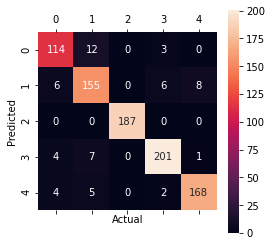

Column-Concatenator classifier score: 0.9254237288135593


In [16]:
y_train_pred = cross_val_predict(concClf, X_train, y_train, cv=10)
confmat = metrics.confusion_matrix(y_train,y_train_pred)
plt.matshow(confmat)
sn.heatmap(confmat,annot=True, annot_kws={"size":10}, fmt='d')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.show()
print('Column-Concatenator classifier score: {}'.format(concClf.score(X_test, y_test)))

In [17]:
#### Column-wise ensembling

In [20]:
ensClf = ColumnEnsembleClassifier(
    estimators=[
        ("TSF0", TimeSeriesForestClassifier(n_estimators=100), [0]),
        ("BOSSEnsemble", BOSSEnsemble(max_ensemble_size=5,n_jobs=-1), [6])])
t = time.time()
ensClf.fit(X_train, y_train)
print('training time: {} sec'.format(round(time.time()-t)))

training time: 1417 sec


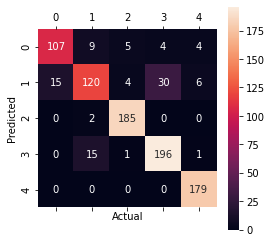

Column-wise ensembling classifier score: 0.9084745762711864


In [21]:
y_train_pred = cross_val_predict(ensClf, X_train, y_train, cv=3)
confmat = metrics.confusion_matrix(y_train,y_train_pred)
plt.matshow(confmat)
sn.heatmap(confmat,annot=True, annot_kws={"size":10}, fmt='d')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.show()
print('Column-wise ensembling classifier score: {}'.format(ensClf.score(X_test, y_test)))